In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import bootstrap
import astropy.units as u
import astropy.constants as conts
import random

In [11]:
### Load data ###
FN_samples_host = pd.read_csv('FN_samples_host_info.csv')
FN_Host_properties = pd.read_csv('FN_Host_properties.csv')
SN_lightcurves = pd.read_csv('SN_lightcurves.csv')

MU_SH0ES = list(FN_samples_host['MU_SH0ES'])
redshift = list(FN_samples_host['zHD'])
redshift_err = list(FN_samples_host['zHDERR'])
m_b_corr = list(FN_samples_host['m_b_corr'])
biasCor_m_b = list(FN_samples_host['biasCor_m_b'])
m_b_corr_err = list(FN_samples_host['m_b_corr_err_DIAG'])
biasCor_m_b_err = list(FN_samples_host['biasCorErr_m_b'])
c = SN_lightcurves['c']
stretch = SN_lightcurves['x1']
cERR = list(FN_samples_host['cERR'])    
x1ERR = list(FN_samples_host['x1ERR'])

# used for excluding Hostless and imcomplete SNe Ia
# [8,114,116,119,138,158,178]
missing_index = [8,47,49,104,114,116,119,133,137,138,158,161,167,173,178] 
MU_SH0ES = [MU_SH0ES[i] for i in range(len(MU_SH0ES)) if i not in missing_index]
redshift = [redshift[i] for i in range(len(redshift)) if i not in missing_index]
m_b_corr = np.array([m_b_corr[i] for i in range(len(m_b_corr)) if i not in missing_index])
biasCor_m_b = np.array([biasCor_m_b[i] for i in range(len(biasCor_m_b)) if i not in missing_index])
m_b_corr_err = np.array([m_b_corr_err[i] for i in range(len(m_b_corr_err)) if i not in missing_index])
biasCor_m_b_err = np.array([biasCor_m_b_err[i] for i in range(len(biasCor_m_b_err)) if i not in missing_index])
cERR = [cERR[i] for i in range(len(cERR)) if i not in missing_index]
x1ERR = [x1ERR[i] for i in range(len(x1ERR)) if i not in missing_index]
redshift_err = [redshift_err[i] for i in range(len(redshift_err)) if i not in missing_index]
#Names_new = list(FN_mass_reorder['Names'])

In [12]:
### Constants ###
MB = -19.253 # From Riess2022 pg 23
MB_err = 0.027
H0 = 73.04 # From Riess2022 eq 10
H0_err = 1.04
alpha = 0.148 # From P21 model in Brout2022 Table 2
beta = 3.09
gamma = -0.003
w = -1 
Omega_M = 0.326 # From Brout2022 pg 12, calcuated from Riess2022 results
Omega_Lambda = 0.674
step = 10 # np.median(FN_mass_reorder['mass'])

# Distance Modulus

In [13]:
### Calculate the Distance Modulus ###

dis_mod = []
dis_mod_err = []

for i in range(len(FN_Host_properties)):
    # Start with 'm_b_corr'
    # Add bias correction 'biasCor_m_b'
    # Take off mass step correction'HOST_LOGMASS' with gamma = -0.003 
    
    mu = m_b_corr[i] + biasCor_m_b[i] - gamma/(1+np.exp((FN_Host_properties['LOGMASS'][i]-step)/0.01)) + gamma/2 - MB

    mu_err1 = np.sqrt(m_b_corr_err[i]**2 + (biasCor_m_b_err[i])**2)
    mu_err = np.sqrt(mu_err1**2 + MB_err**2)

    dis_mod.append(mu)
    dis_mod_err.append(mu_err)

In [14]:
# Define a function for the Hubble parameter
def H(z):
    return 1/(H0 * np.sqrt(Omega_M*(1+z)**3 + Omega_Lambda*(1+z)**(3*(1+w))))

In [15]:
# Calculate theoritical distance modulus for each redshift
z_theory = redshift
mu_theory = []

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=73.04, Om0=0.326)

for z in z_theory:
    d_L = cosmo.luminosity_distance(z) 
    mu = 5 * np.log10(d_L / u.Mpc) +25
    mu_theory.append(mu)

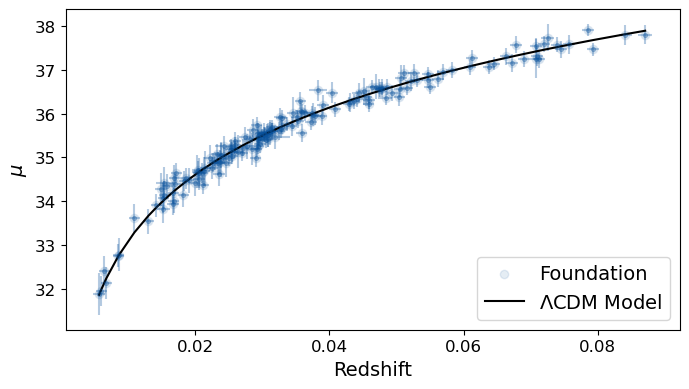

In [16]:
plt.figure(figsize = (7,4))
plt.scatter(redshift, list(dis_mod), label = "Foundation",alpha = 0.1,color='#08519c')
plt.errorbar(redshift, dis_mod, xerr = redshift_err, yerr = dis_mod_err,alpha = 0.3,color='#08519c',fmt='.')
plt.plot(z_theory, mu_theory, 'k', label = '$\\Lambda$CDM Model')
plt.legend(loc = 'lower right', fontsize = 14)
plt.xlabel("Redshift", fontsize = 14)
plt.ylabel("$\\mu$", fontsize = 14)
#plt.title("Hubble Diagram")
plt.tick_params(labelsize=12)
plt.tight_layout()
#plt.savefig("Hubble_Diagram.pdf",bbox_inches='tight')

# Hubble Residuals

In [17]:
HRs = []
for i in range(len(list(dis_mod))):
    HR = dis_mod[i] - mu_theory[i]
    HRs.append(HR)

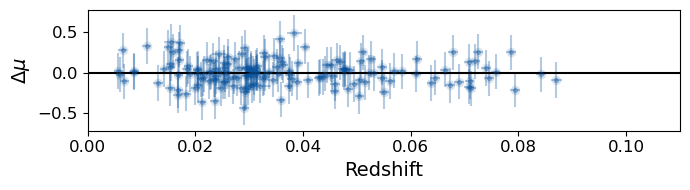

In [18]:
plt.figure(figsize = (7,2))
plt.scatter(redshift, list(HRs), label = "Foundation",alpha = 0.1,color='#08519c')
plt.errorbar(redshift, list(HRs), xerr = redshift_err, yerr = mu_err, fmt = '.', alpha = 0.3,color='#08519c')
plt.hlines(0,0,0.11, color = 'k', label = '$\\Lambda$CDM Model')
plt.xlim(0,0.11)
#plt.legend(loc = 'lower right', fontsize = 14)
plt.xlabel("Redshift", fontsize = 14)
plt.ylabel("$\\Delta\\mu$", fontsize = 14)
#plt.title("Hubble Diagram", fontsize = 16)
plt.tick_params(labelsize=12)
plt.tight_layout()
#plt.savefig("Residuals vs z.pdf",bbox_inches='tight')

# Hubble Residual Step in Mass

## Mass-step using mean of the residuals

In [19]:
# Mass and Hubble Residuals arrays for SNe in high-mass galaxies
above_mass = []
above_mu = []
above_err = []

# Mass and Hubble Residuals arrays for SNe in low-mass galaxies
below_mass = []
below_mu = []
below_err = []

for i in range(len(list(FN_Host_properties['LOGMASS']))):
    if float(list(FN_Host_properties['LOGMASS'])[i]) >= step: # Position of the mass step
        above_mass.append(float(list(FN_Host_properties['LOGMASS'])[i]))
        above_mu.append(float(HRs[i]))
        above_err.append(float(dis_mod_err[i]))
    else: 
        below_mass.append(float(list(FN_Host_properties['LOGMASS'])[i]))
        below_mu.append(float(HRs[i]))
        below_err.append(float(dis_mod_err[i]))

# Calculate the mass step
mass_step = np.mean(below_mu) - np.mean(above_mu) # Save the value of the mass step

# Bootstrap resampling
boots1 = bootstrap((np.array(below_mu), ), np.mean, confidence_level=0.9,method='percentile')
std_1 = boots1.standard_error
boots2 = bootstrap((np.array(above_mu), ), np.mean, confidence_level=0.9,method='percentile')
std_2 = boots2.standard_error

mass_step_err = np.sqrt(std_1**2 + std_2**2)

print("Mass step using mean residuals: ", mass_step, "±", mass_step_err,"with the step at", step)

Mass step using mean residuals:  0.0730137296829452 ± 0.02569675844201803 with the step at 10


## Mass-step using median of the residuals 

In [20]:
mass_step_median = np.median(below_mu) - np.median(above_mu) # Save the value of the mass step

# Bootstrap resampling
boots1_median = bootstrap((np.array(below_mu), ), np.median, confidence_level=0.9,method='percentile')
std_1_median = boots1_median.standard_error
boots2_median = bootstrap((np.array(above_mu), ), np.median, confidence_level=0.9,method='percentile')
std_2_median = boots2_median.standard_error

mass_step_err_median = np.sqrt(std_1_median**2 + std_2_median**2)

print("Mass step using median residuals: ", mass_step_median,"±", mass_step_err_median,"with the step at", step)

Mass step using median residuals:  0.06638265165007695 ± 0.02407763110662672 with the step at 10


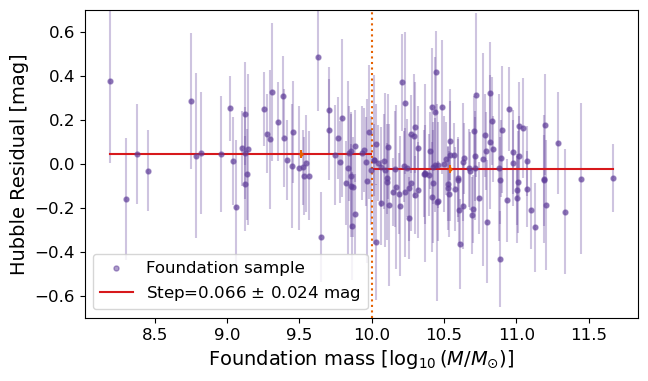

In [21]:
fig = plt.figure(figsize=(9, 4))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
y1 = [np.median(below_mu)]*100
x1 = np.linspace(np.min(below_mass),np.max(below_mass),100)
y2 = [np.median(above_mu)]*100
x2 = np.linspace(np.min(above_mass),np.max(above_mass),100)
# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(FN_Host_properties['LOGMASS'],HRs, color='#5e3c99',zorder=5,marker='o',s=13,alpha=0.5,label='Foundation sample')
ax_scatter.errorbar(FN_Host_properties['LOGMASS'],HRs, yerr=dis_mod_err, fmt = 'o',alpha=0.3,color='#5e3c99',markersize=2)
ax_scatter.axvline(step,linestyle='dotted',color='#e66101',markersize=4)
ax_scatter.plot(x1,y1,color='#d7191c',markersize=4,label = f"Step={mass_step_median:.3f} $\\pm$ {mass_step_err_median:.3f} mag")
ax_scatter.plot(x2,y2,color='#d7191c',markersize=4)
ax_scatter.errorbar([np.median(below_mass),np.median(above_mass)],[np.median(below_mu),np.median(above_mu)],
                    yerr=[std_1_median,std_2_median],fmt='o',color='#e66101',markersize=2)

ax_scatter.set_xlabel('Foundation mass [$\log_{10}(M / M_{\odot})$]',fontsize=14)
ax_scatter.set_ylabel('Hubble Residual [mag]',fontsize=14)
# ax_scatter.axes.set_xlim(0.2, 2.5)
ax_scatter.axes.set_ylim(-0.7, 0.7)
#ax_scatter.text(10.5, -0.6, f'Step: {mass_step_median:.4f} ± {mass_step_err_median:.4f}', fontsize=10)
ax_scatter.legend(fontsize=12)
#ax_scatter.legend(loc='lower right')
plt.tick_params(labelsize=12)
#plt.savefig('FN_HR vs M.pdf',bbox_inches='tight')
plt.show()

## Mass-step using weighted mean of the residuals

In [22]:
# Calculate the weights for each subsamples
weights_below = []
for i in range(len(below_err)):
    weights_below.append(1/below_err[i]**2)

weights_above = []
for i in range(len(above_err)):
    weights_above.append(1/above_err[i]**2)


# Calculate the weighted mean of the residuals
weighted_mean_below = np.sum(np.array(below_mu)*weights_below)/np.sum(weights_below)
weighted_mean_above = np.sum(np.array(above_mu)*weights_above)/np.sum(weights_above)

# Calculate the weighted mean of the mass
weighted_mean_mass_below = np.sum(np.array(below_mass)*weights_below)/np.sum(weights_below)
weighted_mean_mass_above = np.sum(np.array(above_mass)*weights_above)/np.sum(weights_above)

# Calculate the mass step
mass_step_weighted_mean = weighted_mean_below - weighted_mean_above


# Bootstrap resampling
n_bootstrap = 1000  # Number of bootstrap samples
bootstrap_means_below = []
bootstrap_means_above = []
below_mu = np.array(below_mu)
above_mu = np.array(above_mu)

# Perform bootstrap sampling
for _ in range(n_bootstrap):
    # Randomly sample indices with replacement
    sample_indices_below = np.random.choice(range(len(below_mu)), size=len(below_mu), replace=True)
    sample_indices_above = np.random.choice(range(len(above_mu)), size=len(above_mu), replace=True)
    
    # Get the resampled data and weights
    resampled_data_below = np.array([below_mu[i] for i in sample_indices_below])
    resampled_weights_below = np.array([weights_below[i] for i in sample_indices_below])
    resampled_data_above = np.array([above_mu[i] for i in sample_indices_above])
    resampled_weights_above = np.array([weights_above[i] for i in sample_indices_above])
    
    # Calculate the weighted mean for the bootstrap sample
    resampled_mean_below = np.sum(resampled_data_below * resampled_weights_below) / np.sum(resampled_weights_below)
    resampled_mean_above = np.sum(resampled_data_above * resampled_weights_above) / np.sum(resampled_weights_above)

    bootstrap_means_below.append(resampled_mean_below)
    bootstrap_means_above.append(resampled_mean_above)

# Convert bootstrap means to a numpy array for easier analysis
bootstrap_means_below = np.array(bootstrap_means_below)
bootstrap_means_above = np.array(bootstrap_means_above)

# Calculate the uncertainty as the standard deviation of the bootstrap means
uncertainty_below = np.std(bootstrap_means_below)
uncertainty_above = np.std(bootstrap_means_above)

mass_step_err_wm = np.sqrt(uncertainty_below**2 + uncertainty_above**2)

print("Mass step using weighted mean residuals: ", mass_step_weighted_mean,"±",mass_step_err_wm ,"with the step at", step)

Mass step using weighted mean residuals:  0.07773842006254977 ± 0.026077113687187407 with the step at 10


In [23]:
# Compute uncertainties on the weighted mean via the formula
uncertainty_below_Eq = np.sqrt(1/np.sum(weights_below))
uncertainty_above_Eq = np.sqrt(1/np.sum(weights_above))

mass_step_err_wm_eq = np.sqrt(uncertainty_below_Eq**2 + uncertainty_above_Eq**2)

print("Mass step using weighted mean residuals: ", mass_step_weighted_mean,"±",mass_step_err_wm_eq ,"with the step at", step)

Mass step using weighted mean residuals:  0.07773842006254977 ± 0.03507018518747214 with the step at 10


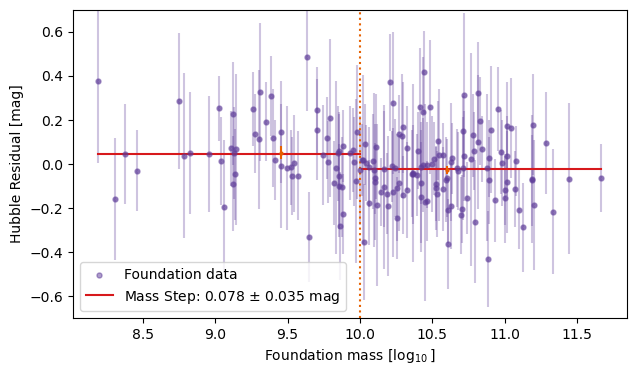

In [24]:
fig = plt.figure(figsize=(9, 4))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
y1 = [np.median(below_mu)]*100
x1 = np.linspace(np.min(below_mass),np.max(below_mass),100)
y2 = [np.median(above_mu)]*100
x2 = np.linspace(np.min(above_mass),np.max(above_mass),100)
# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(FN_Host_properties['LOGMASS'],HRs, color='#5e3c99',zorder=5,marker='o',s=13,alpha=0.5,label='Foundation data')
ax_scatter.errorbar(FN_Host_properties['LOGMASS'],HRs, yerr=dis_mod_err, fmt = 'o',alpha=0.3,color='#5e3c99',markersize=2)
ax_scatter.axvline(step,linestyle='dotted',color='#e66101',markersize=4)
ax_scatter.plot(x1,y1,color='#d7191c',markersize=4,label = f"Mass Step: {mass_step_weighted_mean:.3f} $\\pm$ {mass_step_err_wm_eq:.3f} mag")
ax_scatter.plot(x2,y2,color='#d7191c',markersize=4)
ax_scatter.errorbar([weighted_mean_mass_below,weighted_mean_mass_above],[weighted_mean_below,weighted_mean_above],
                    yerr=[uncertainty_below_Eq,uncertainty_above_Eq],fmt='o',color='#e66101',markersize=2)

ax_scatter.set_xlabel('Foundation mass [$\log_{10}$]')
ax_scatter.set_ylabel('Hubble Residual [mag]')
# ax_scatter.axes.set_xlim(0.2, 2.5)
ax_scatter.axes.set_ylim(-0.7, 0.7)
#ax_scatter.text(10.5, -0.6, f'Step: {mass_step_median:.4f} ± {mass_step_err_median:.4f}', fontsize=10)
ax_scatter.legend()
#ax_scatter.legend(loc='lower right')

#plt.savefig('FN_HR vs M-wm.pdf')
plt.show()

# Hubble Residual Step in Colour

In [25]:
FN_Host_Properties = pd.read_csv('FN_Host_Properties.csv')
FN_lightcurves = pd.read_csv('SN_lightcurves.csv') # SN lightcurve parameters c & x1

mergedHost_lc = pd.merge(FN_lightcurves, FN_Host_Properties, how='inner')

In [26]:
median_UR = np.median(FN_Host_Properties['U-R Color'])

# Mass and Hubble Residuals arrays for SNe in redder  galaxies
redder_UR = []
redder_mu = []
redder_err = []

# Mass and Hubble Residuals arrays for SNe in bluer galaxies
bluer_UR = []
bluer_mu = []
bluer_err = []

for i in range(len(list(FN_Host_Properties['U-R Color']))):
    if float(list(FN_Host_Properties['U-R Color'])[i]) >= median_UR: # Position of the color step
        redder_UR.append(float(list(FN_Host_Properties['U-R Color'])[i]))
        redder_mu.append(float(HRs[i]))
        redder_err.append(float(dis_mod_err[i]))
    else: 
        bluer_UR.append(float(list(FN_Host_Properties['U-R Color'])[i]))
        bluer_mu.append(float(HRs[i]))
        bluer_err.append(float(dis_mod_err[i]))

# Calculate the mass step
color_step = np.median(bluer_mu) - np.median(redder_mu) # Save the value of the mass step


# Bootstrap resampling
boots_bluer = bootstrap((np.array(bluer_mu), ), np.median, confidence_level=0.9,method='percentile')
std_bluer = boots_bluer.standard_error
boots_redder = bootstrap((np.array(redder_mu), ), np.median, confidence_level=0.9,method='percentile')
std_redder = boots_redder.standard_error

color_step_err = np.sqrt(std_bluer**2 + std_redder**2)

print("Color step using median residuals: ", color_step, "±", color_step_err,"with the step at", median_UR)

Color step using median residuals:  0.04949622521794339 ± 0.024737369864985943 with the step at 1.07334627041161


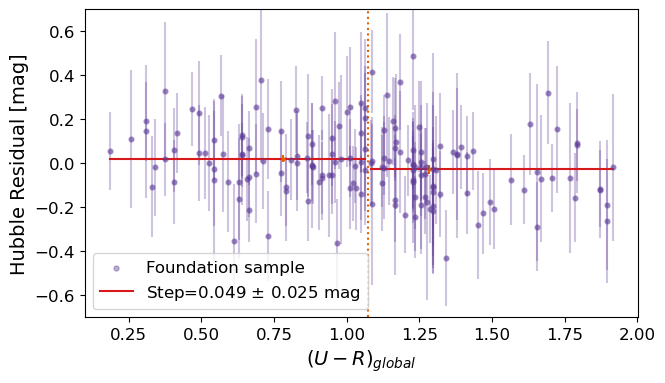

In [27]:
fig = plt.figure(figsize=(9, 4))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
y1 = [np.median(bluer_mu)]*100
x1 = np.linspace(np.min(bluer_UR),np.max(bluer_UR),100)
y2 = [np.median(redder_mu)]*100
x2 = np.linspace(np.min(redder_UR),np.max(redder_UR),100)
# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(FN_Host_Properties['U-R Color'],HRs, color='#5e3c99',zorder=5,marker='o',s=13,alpha=0.4,label='Foundation sample')
ax_scatter.errorbar(FN_Host_Properties['U-R Color'],HRs, yerr=dis_mod_err, fmt = 'o',alpha=0.3,color='#5e3c99',markersize=2)
ax_scatter.axvline(median_UR,linestyle='dotted',color='#e66101',markersize=4)
ax_scatter.plot(x1,y1,color='#d7191c',markersize=4,label = f"Step={color_step:.3f} $\\pm$ {color_step_err:.3f} mag")
ax_scatter.plot(x2,y2,color='#d7191c',markersize=4)
ax_scatter.errorbar([np.median(bluer_UR),np.median(redder_UR)],[np.median(bluer_mu),np.median(redder_mu)],
                    yerr=[std_bluer,std_redder],fmt='o',color='#e66101',markersize=2)

ax_scatter.set_xlabel('$(U-R)_{global}$',fontsize=14)
ax_scatter.set_ylabel('Hubble Residual [mag]',fontsize=14)
# ax_scatter.axes.set_xlim(0.2, 2.5)
ax_scatter.axes.set_ylim(-0.7, 0.7)
#ax_scatter.text(10.5, -0.6, f'Step: {mass_step_median:.4f} ± {mass_step_err_median:.4f}', fontsize=10)
ax_scatter.legend(loc='lower left',fontsize=12)
#ax_scatter.legend(loc='lower right')
plt.tick_params(labelsize=12)
#plt.savefig('FN_HR vs U-R.pdf',bbox_inches='tight')
plt.show()

In [28]:
# Calculate the weights for each subsamples
weights_below = []
for i in range(len(bluer_err)):
    weights_below.append(1/bluer_err[i]**2)

weights_above = []
for i in range(len(redder_err)):
    weights_above.append(1/redder_err[i]**2)


# Calculate the weighted mean of the residuals
weighted_mean_below = np.sum(np.array(bluer_mu)*weights_below)/np.sum(weights_below)
weighted_mean_above = np.sum(np.array(redder_mu)*weights_above)/np.sum(weights_above)

# Calculate the weighted mean of the mass
weighted_mean_UR_below = np.sum(np.array(bluer_mu)*weights_below)/np.sum(weights_below)
weighted_mean_UR_above = np.sum(np.array(redder_mu)*weights_above)/np.sum(weights_above)

# Calculate the mass step
color_step_weighted_mean = weighted_mean_below - weighted_mean_above


# Bootstrap resampling
n_bootstrap = 1000  # Number of bootstrap samples
bootstrap_means_below = []
bootstrap_means_above = []
below_mu = np.array(bluer_mu)
above_mu = np.array(redder_mu)

# Perform bootstrap sampling
for _ in range(n_bootstrap):
    # Randomly sample indices with replacement
    sample_indices_below = np.random.choice(range(len(bluer_mu)), size=len(bluer_mu), replace=True)
    sample_indices_above = np.random.choice(range(len(redder_mu)), size=len(redder_mu), replace=True)
    
    # Get the resampled data and weights
    resampled_data_below = np.array([bluer_mu[i] for i in sample_indices_below])
    resampled_weights_below = np.array([weights_below[i] for i in sample_indices_below])
    resampled_data_above = np.array([redder_mu[i] for i in sample_indices_above])
    resampled_weights_above = np.array([weights_above[i] for i in sample_indices_above])
    
    # Calculate the weighted mean for the bootstrap sample
    resampled_mean_below = np.sum(resampled_data_below * resampled_weights_below) / np.sum(resampled_weights_below)
    resampled_mean_above = np.sum(resampled_data_above * resampled_weights_above) / np.sum(resampled_weights_above)

    bootstrap_means_below.append(resampled_mean_below)
    bootstrap_means_above.append(resampled_mean_above)

# Convert bootstrap means to a numpy array for easier analysis
bootstrap_means_below = np.array(bootstrap_means_below)
bootstrap_means_above = np.array(bootstrap_means_above)

# Calculate the uncertainty as the standard deviation of the bootstrap means
uncertainty_below = np.std(bootstrap_means_below)
uncertainty_above = np.std(bootstrap_means_above)

mass_step_err_wm = np.sqrt(uncertainty_below**2 + uncertainty_above**2)

print("Colour step using weighted mean residuals: ", color_step_weighted_mean,"±",mass_step_err_wm ,"with the step at", median_UR)

Colour step using weighted mean residuals:  0.05574515975243691 ± 0.024719981630209772 with the step at 1.07334627041161


# Hubble Residual Step in dDLR

In [29]:
median_dDLR = np.median(FN_Host_Properties['dDLR'])

# Mass and Hubble Residuals arrays for SNe in redder  galaxies
inner_dDLR = []
inner_mu = []
inner_err = []
inner_M = []
inner_UR = []

# Mass and Hubble Residuals arrays for SNe in bluer galaxies
outer_dDLR = []
outer_mu = []
outer_err = []
outer_M = []
outer_UR = []

filtered_dDLR = [x for x in list(FN_Host_Properties['dDLR']) if x > 0 and x <= 4]

for i in range(len(FN_Host_Properties['dDLR'])):
    if float(FN_Host_Properties['dDLR'][i]) >= 1: # Position of the color step
        outer_dDLR.append(float(FN_Host_Properties['dDLR'][i]))
        outer_mu.append(float(HRs[i]))
        outer_err.append(float(dis_mod_err[i]))
        outer_M.append(float(FN_Host_Properties['LOGMASS'][i]))
        outer_UR.append(float(FN_Host_Properties['U-R Color'][i]))
    else: 
        inner_dDLR.append(float(FN_Host_Properties['dDLR'][i]))
        inner_mu.append(float(HRs[i]))
        inner_err.append(float(dis_mod_err[i]))
        inner_M.append(float(FN_Host_Properties['LOGMASS'][i]))
        inner_UR.append(float(FN_Host_Properties['U-R Color'][i]))

# Calculate the mass step
dDLR_step = np.median(inner_mu) - np.median(outer_mu) # Save the value of the mass step


# Bootstrap resampling
boots_inner = bootstrap((np.array(inner_mu), ), np.median, confidence_level=0.9,method='percentile')
std_inner = boots_inner.standard_error
boots_outer = bootstrap((np.array(outer_mu), ), np.median, confidence_level=0.9,method='percentile')
std_outer = boots_outer.standard_error

dDLR_step_err = np.sqrt(std_inner**2 + std_outer**2)

print("dDLR step using median: ", dDLR_step, "±", dDLR_step_err,"with the step at", 1)
print(len(inner_dDLR),len(outer_dDLR))

dDLR step using median:  -0.058784396100797665 ± 0.023539893381008627 with the step at 1
59 105


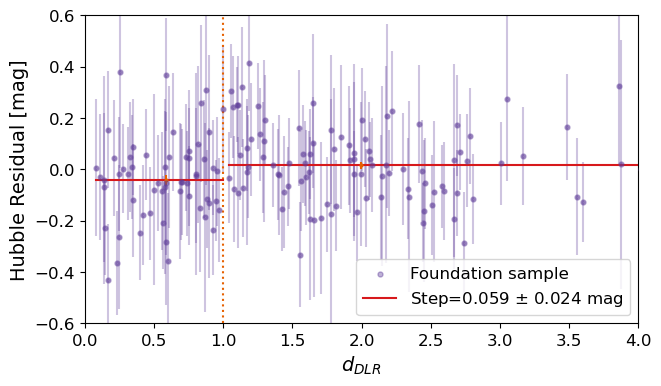

In [30]:
fig = plt.figure(figsize=(9, 4))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
y1 = [np.median(inner_mu)]*100
x1 = np.linspace(np.min(inner_dDLR),np.max(inner_dDLR),100)
y2 = [np.median(outer_mu)]*100
x2 = np.linspace(np.min(outer_dDLR),np.max(outer_dDLR),100)
# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(FN_Host_Properties['dDLR'],HRs, color='#5e3c99',zorder=5,marker='o',s=13,alpha=0.4,label='Foundation sample')
ax_scatter.errorbar(FN_Host_Properties['dDLR'],HRs, yerr=dis_mod_err, fmt = 'o',alpha=0.3,color='#5e3c99',markersize=2)
ax_scatter.axvline(1,linestyle='dotted',color='#e66101',markersize=4)
ax_scatter.plot(x1,y1,color='#d7191c',markersize=4,label = f"Step={-dDLR_step:.3f} $\\pm$ {dDLR_step_err:.3f} mag")
ax_scatter.plot(x2,y2,color='#d7191c',markersize=4)
ax_scatter.errorbar([np.median(inner_dDLR),np.median(outer_dDLR)],[np.median(inner_mu),np.median(outer_mu)],
                    yerr=[std_inner,std_outer],fmt='o',color='#e66101',markersize=2)

ax_scatter.set_xlabel('$d_{DLR}$',fontsize=14)
ax_scatter.set_ylabel('Hubble Residual [mag]',fontsize=14)
ax_scatter.axes.set_ylim(-0.6, 0.6)
ax_scatter.axes.set_xlim(0, 4)
#ax_scatter.text(10.5, -0.6, f'Step: {mass_step_median:.4f} ± {mass_step_err_median:.4f}', fontsize=10)
ax_scatter.legend(fontsize=12)
#ax_scatter.legend(loc='lower right')
plt.tick_params(labelsize=12)
#plt.savefig('FN_HR vs dDLR.pdf',bbox_inches='tight')
plt.show()

In [31]:
# Calculate the weights for each subsamples
weights_inner = []
for i in range(len(inner_err)):
    weights_inner.append(1/inner_err[i]**2)

weights_outer = []
for i in range(len(outer_err)):
    weights_outer.append(1/outer_err[i]**2)


# Calculate the weighted mean of the residuals
weighted_mean_inner = np.sum(np.array(inner_mu)*weights_inner)/np.sum(weights_inner)
weighted_mean_outer = np.sum(np.array(outer_mu)*weights_outer)/np.sum(weights_outer)

# Calculate the weighted mean of the mass
weighted_mean_mass_inner = np.sum(np.array(inner_M)*weights_inner)/np.sum(weights_inner)
weighted_mean_mass_outer = np.sum(np.array(outer_M)*weights_outer)/np.sum(weights_outer)

# Calculate the mass step
dDLR_step_weighted_mean = weighted_mean_inner - weighted_mean_outer


# Bootstrap resampling
n_bootstrap = 1000  # Number of bootstrap samples
bootstrap_means_inner = []
bootstrap_means_outer = []
below_mu = np.array(inner_mu)
above_mu = np.array(outer_mu)

# Perform bootstrap sampling
for _ in range(n_bootstrap):
    # Randomly sample indices with replacement
    sample_indices_inner = np.random.choice(range(len(inner_mu)), size=len(inner_mu), replace=True)
    sample_indices_outer = np.random.choice(range(len(outer_mu)), size=len(outer_mu), replace=True)
    
    # Get the resampled data and weights
    resampled_data_inner = np.array([inner_mu[i] for i in sample_indices_inner])
    resampled_weights_inner = np.array([weights_inner[i] for i in sample_indices_inner])
    resampled_data_outer = np.array([outer_mu[i] for i in sample_indices_outer])
    resampled_weights_outer = np.array([weights_outer[i] for i in sample_indices_outer])
    
    # Calculate the weighted mean for the bootstrap sample
    resampled_mean_inner = np.sum(resampled_data_inner * resampled_weights_inner) / np.sum(resampled_weights_inner)
    resampled_mean_outer = np.sum(resampled_data_outer * resampled_weights_outer) / np.sum(resampled_weights_outer)

    bootstrap_means_inner.append(resampled_mean_inner)
    bootstrap_means_outer.append(resampled_mean_outer)

# Convert bootstrap means to a numpy array for easier analysis
bootstrap_means_inner = np.array(bootstrap_means_inner)
bootstrap_means_outer = np.array(bootstrap_means_outer)

# Calculate the uncertainty as the standard deviation of the bootstrap means
uncertainty_inner = np.std(bootstrap_means_inner)
uncertainty_outer = np.std(bootstrap_means_outer)

dDLR_step_err_wm = np.sqrt(uncertainty_inner**2 + uncertainty_outer**2)

print("dDLR step using weighted mean residuals: ", dDLR_step_weighted_mean,"±",dDLR_step_err_wm ,"with the step at", 1)

dDLR step using weighted mean residuals:  -0.07398025816945664 ± 0.02588112099200213 with the step at 1


# Split SNe based on the dDLR

## Inner region mass-step

In [32]:
# Mass and Hubble Residuals arrays for bluer SNe (c<0) in low-mass galaxies
innerSN_below_mass = []
innerSN_below_mu = []
innerSN_below_err = []

# Mass and Hubble Residuals arrays for bluer SNe (c<0) in high-mass galaxies
innerSN_above_mass = []
innerSN_above_mu = []
innerSN_above_err = []


for i in range(len(list(inner_M))):
    if float(list(inner_M)[i]) >= step: # Position of the mass step
        innerSN_above_mass.append(float(list(inner_M)[i]))
        innerSN_above_mu.append(float(inner_mu[i]))
        innerSN_above_err.append(float(inner_err[i]))
    else: 
        innerSN_below_mass.append(float(list(inner_M)[i]))
        innerSN_below_mu.append(float(inner_mu[i]))
        innerSN_below_err.append(float(inner_err[i]))

# Calculate the mass step for bluer SNe
innerSN_mass_step = np.median(innerSN_below_mu) - np.median(innerSN_above_mu) # Save the value of the mass step

# Bootstrap resampling
innerSNm_boots1 = bootstrap((np.array(innerSN_below_mu), ), np.median, confidence_level=0.9,method='percentile')
innerSNm_std_1 = innerSNm_boots1.standard_error
innerSNm_boots2 = bootstrap((np.array(innerSN_above_mu), ), np.median, confidence_level=0.9,method='percentile')
innerSNm_std_2 = innerSNm_boots2.standard_error
innerSN_mass_step_err = np.sqrt(innerSNm_std_1**2 + innerSNm_std_2**2)

print("Mass step in inner group: ", innerSN_mass_step, "±", innerSN_mass_step_err,"with the step at", 1)

Mass step in inner group:  0.09426213164138275 ± 0.03962716403241143 with the step at 1


## Outer region mass-step

In [33]:
# Mass and Hubble Residuals arrays for bluer SNe (c<0) in low-mass galaxies
outerSN_below_mass = []
outerSN_below_mu = []
outerSN_below_err = []

# Mass and Hubble Residuals arrays for bluer SNe (c<0) in high-mass galaxies
outerSN_above_mass = []
outerSN_above_mu = []
outerSN_above_err = []

for i in range(len(list(outer_M))):
    if float(list(outer_M)[i]) >= step: # Position of the mass step
        outerSN_above_mass.append(float(list(outer_M)[i]))
        outerSN_above_mu.append(float(outer_mu[i]))
        outerSN_above_err.append(float(outer_err[i]))
    else: 
        outerSN_below_mass.append(float(list(outer_M)[i]))
        outerSN_below_mu.append(float(outer_mu[i]))
        outerSN_below_err.append(float(outer_err[i]))


# Calculate the mass step for bluer SNe
outerSN_mass_step = np.median(outerSN_below_mu) - np.median(outerSN_above_mu) # Save the value of the mass step

# Bootstrap resampling
outerSNm_boots1 = bootstrap((np.array(outerSN_below_mu), ), np.median, confidence_level=0.9,method='percentile')
outerSNm_std_1 = outerSNm_boots1.standard_error
outerSNm_boots2 = bootstrap((np.array(outerSN_above_mu), ), np.median, confidence_level=0.9,method='percentile')
outerSNm_std_2 = outerSNm_boots2.standard_error
outerSN_mass_step_err = np.sqrt(outerSNm_std_1**2 + outerSNm_std_2**2)

print("Mass step in outer group: ", outerSN_mass_step, "±", outerSN_mass_step_err,"with the step at", 1)

Mass step in outer group:  0.06444179402426187 ± 0.0372903883703686 with the step at 1


## Mass-step plot for inner and outer region

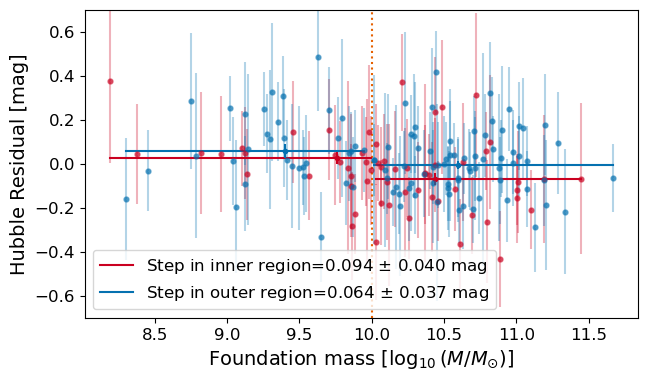

In [34]:
fig = plt.figure(figsize=(9, 4))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
yb1 = [np.median(innerSN_below_mu)]*100
xb1 = np.linspace(np.min(innerSN_below_mass),np.max(innerSN_below_mass),100)
yb2 = [np.median(innerSN_above_mu)]*100
xb2 = np.linspace(np.min(innerSN_above_mass),np.max(innerSN_above_mass),100)
aB,bB = np.polyfit(inner_M,inner_mu,1)

yr1 = [np.median(outerSN_below_mu)]*100
xr1 = np.linspace(np.min(outerSN_below_mass),np.max(outerSN_below_mass),100)
yr2 = [np.median(outerSN_above_mu)]*100
xr2 = np.linspace(np.min(outerSN_above_mass),np.max(outerSN_above_mass),100)
aR,bR = np.polyfit(outer_M,outer_mu,1)

# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(inner_M,inner_mu, color='#ca0020',zorder=5,marker='o',s=13,alpha=0.5)
#ax_scatter.plot(blueSN_mass,aB*np.array(blueSN_mass)+bB,color='#0571b0')
ax_scatter.errorbar(inner_M,inner_mu,  yerr=inner_err, fmt = 'o',alpha=0.3,color='#ca0020',markersize=2)

ax_scatter.scatter(outer_M,outer_mu, color='#0571b0',zorder=5,marker='o',s=13,alpha=0.5)
#ax_scatter.plot(redSN_mass,aR*np.array(redSN_mass)+bR,color='#ca0020')
ax_scatter.errorbar(outer_M,outer_mu,  yerr=outer_err, fmt = 'o',alpha=0.3,color='#0571b0',markersize=2)
ax_scatter.axvline(step,linestyle='dotted',color='#e66101',markersize=4)

ax_scatter.plot(xb1,yb1,color='#ca0020',markersize=4,label = f"Step in inner region={innerSN_mass_step:.3f} $\\pm$ {innerSN_mass_step_err:.3f} mag")
ax_scatter.plot(xb2,yb2,color='#ca0020',markersize=4)
ax_scatter.errorbar([np.median(innerSN_below_mass),np.median(innerSN_above_mass)],[np.median(innerSN_below_mu),np.median(innerSN_above_mu)],
                    yerr=[innerSNm_std_1,innerSNm_std_2],fmt='o',color='#ca0020',markersize=3)

ax_scatter.plot(xr1,yr1,color='#0571b0',markersize=4,label = f"Step in outer region={outerSN_mass_step:.3f} $\\pm$ {outerSN_mass_step_err:.3f} mag")
ax_scatter.plot(xr2,yr2,color='#0571b0',markersize=4)
ax_scatter.errorbar([np.median(outerSN_below_mass),np.median(outerSN_above_mass)],[np.median(outerSN_below_mu),np.median(outerSN_above_mu)],
                    yerr=[outerSNm_std_1,outerSNm_std_2],fmt='o',color='#0571b0',markersize=3)


ax_scatter.set_xlabel('Foundation mass [$\log_{10}(M / M_{\odot})$]',fontsize=14)
ax_scatter.set_ylabel('Hubble Residual [mag]',fontsize=14)
# ax_scatter.axes.set_xlim(0.2, 2.5)
ax_scatter.axes.set_ylim(-0.7, 0.7)
#ax_scatter.text(10.5, -0.6, f'Step: {mass_step_median:.4f} ± {mass_step_err_median:.4f}', fontsize=10)
ax_scatter.legend(fontsize=12)
#ax_scatter.legend(loc='lower right')
plt.tick_params(labelsize=12)
#plt.savefig('FN_HR vs M inner_outer.pdf',bbox_inches='tight')
plt.show()

# Split SNe into blue and red groups

In [35]:
# Mass and Hubble Residuals arrays for bluer SNe (c<0)
blueSN_mass = []
blueSN_UR = []
blueSN_mu = []
blueSN_err = []

# Mass and Hubble Residuals arrays for redder SNe (c>0)
redSN_mass = []
redSN_UR = []
redSN_mu = []
redSN_err = []

for i in range(len(list(mergedHost_lc['c']))):
    if float(list(list(mergedHost_lc['c']))[i]) <= 0: 
        blueSN_mass.append(float(list(FN_Host_Properties['LOGMASS'])[i]))
        blueSN_UR.append(float(list(FN_Host_Properties['U-R Color'])[i]))
        blueSN_mu.append(float(HRs[i]))
        blueSN_err.append(float(dis_mod_err[i]))
    else: 
        redSN_mass.append(float(list(FN_Host_Properties['LOGMASS'])[i]))
        redSN_UR.append(float(list(FN_Host_Properties['U-R Color'])[i]))
        redSN_mu.append(float(HRs[i]))
        redSN_err.append(float(dis_mod_err[i]))

## Blue Group mass step

In [36]:
# Mass and Hubble Residuals arrays for bluer SNe (c<0) in low-mass galaxies
blueSN_below_mass = []
blueSN_below_mu = []
blueSN_below_err = []

# Mass and Hubble Residuals arrays for bluer SNe (c<0) in high-mass galaxies
blueSN_above_mass = []
blueSN_above_mu = []
blueSN_above_err = []


for i in range(len(list(blueSN_mass))):
    if float(list(blueSN_mass)[i]) >= step: # Position of the mass step
        blueSN_above_mass.append(float(list(blueSN_mass)[i]))
        blueSN_above_mu.append(float(blueSN_mu[i]))
        blueSN_above_err.append(float(blueSN_err[i]))
    else: 
        blueSN_below_mass.append(float(list(blueSN_mass)[i]))
        blueSN_below_mu.append(float(blueSN_mu[i]))
        blueSN_below_err.append(float(blueSN_err[i]))


# Calculate the mass step for bluer SNe
blueSN_mass_step = np.median(blueSN_below_mu) - np.median(blueSN_above_mu) # Save the value of the mass step

# Bootstrap resampling
blueSNm_boots1 = bootstrap((np.array(blueSN_below_mu), ), np.median, confidence_level=0.9,method='percentile')
blueSNm_std_1 = blueSNm_boots1.standard_error
blueSNm_boots2 = bootstrap((np.array(blueSN_above_mu), ), np.median, confidence_level=0.9,method='percentile')
blueSNm_std_2 = blueSNm_boots2.standard_error
blueSN_mass_step_err = np.sqrt(blueSNm_std_1**2 + blueSNm_std_2**2)


print("Mass step in blue group: ", blueSN_mass_step, "±", blueSN_mass_step_err,"with the step at", step)

Mass step in blue group:  0.04094796845855697 ± 0.027544502633926084 with the step at 10


## Red Group mass step

In [37]:
# Mass and Hubble Residuals arrays for redder SNe (c<0) in low-mass galaxies
redSN_below_mass = []
redSN_below_mu = []
redSN_below_err = []

# Mass and Hubble Residuals arrays for redder SNe (c<0) in high-mass galaxies
redSN_above_mass = []
redSN_above_mu = []
redSN_above_err = []


for i in range(len(list(redSN_mass))):
    if float(list(redSN_mass)[i]) >= step: # Position of the mass step
        redSN_above_mass.append(float(list(redSN_mass)[i]))
        redSN_above_mu.append(float(redSN_mu[i]))
        redSN_above_err.append(float(redSN_err[i]))
    else: 
        redSN_below_mass.append(float(list(redSN_mass)[i]))
        redSN_below_mu.append(float(redSN_mu[i]))
        redSN_below_err.append(float(redSN_err[i]))

# Calculate the mass step for bluer SNe
redSN_mass_step = np.median(redSN_below_mu) - np.median(redSN_above_mu) # Save the value of the mass step


# Bootstrap resampling
redSN_boots1 = bootstrap((np.array(redSN_below_mu), ), np.median, confidence_level=0.9,method='percentile')
redSN_std_1 = redSN_boots1.standard_error
redSN_boots2 = bootstrap((np.array(redSN_above_mu), ), np.median, confidence_level=0.9,method='percentile')
redSN_std_2 = redSN_boots2.standard_error

redSN_mass_step_err = np.sqrt(redSN_std_1**2 + redSN_std_2**2)

print("Mass step in red group: ", redSN_mass_step, "±", redSN_mass_step_err,"with the step at", step)

Mass step in red group:  0.10594403528083163 ± 0.04257869948119714 with the step at 10


## Mass step plot with SNe splitted into blue and red groups

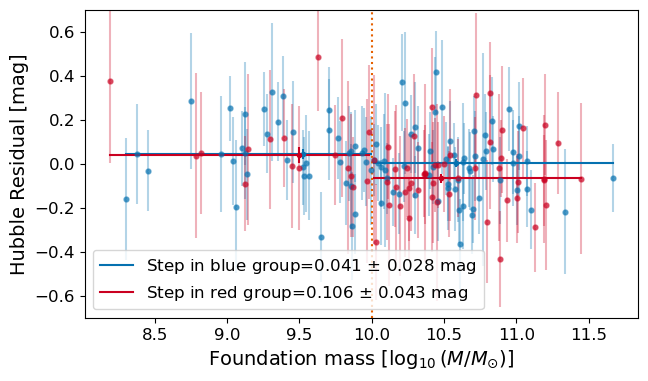

In [38]:
fig = plt.figure(figsize=(9, 4))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
yb1 = [np.median(blueSN_below_mu)]*100
xb1 = np.linspace(np.min(blueSN_below_mass),np.max(blueSN_below_mass),100)
yb2 = [np.median(blueSN_above_mu)]*100
xb2 = np.linspace(np.min(blueSN_above_mass),np.max(blueSN_above_mass),100)
aB,bB = np.polyfit(blueSN_mass,blueSN_mu,1)

yr1 = [np.median(redSN_below_mu)]*100
xr1 = np.linspace(np.min(redSN_below_mass),np.max(redSN_below_mass),100)
yr2 = [np.median(redSN_above_mu)]*100
xr2 = np.linspace(np.min(redSN_above_mass),np.max(redSN_above_mass),100)
aR,bR = np.polyfit(redSN_mass,redSN_mu,1)

# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(blueSN_mass,blueSN_mu, color='#0571b0',zorder=5,marker='o',s=13,alpha=0.5)
#ax_scatter.plot(blueSN_mass,aB*np.array(blueSN_mass)+bB,color='#0571b0')
ax_scatter.errorbar(blueSN_mass,blueSN_mu,  yerr=blueSN_err, fmt = 'o',alpha=0.3,color='#0571b0',markersize=2)

ax_scatter.scatter(redSN_mass,redSN_mu, color='#ca0020',zorder=5,marker='o',s=13,alpha=0.5)
#ax_scatter.plot(redSN_mass,aR*np.array(redSN_mass)+bR,color='#ca0020')
ax_scatter.errorbar(redSN_mass,redSN_mu,  yerr=redSN_err, fmt = 'o',alpha=0.3,color='#ca0020',markersize=2)
ax_scatter.axvline(step,linestyle='dotted',color='#e66101',markersize=4)

ax_scatter.plot(xb1,yb1,color='#0571b0',markersize=4,label = f"Step in blue group={blueSN_mass_step:.3f} $\\pm$ {blueSN_mass_step_err:.3f} mag")
ax_scatter.plot(xb2,yb2,color='#0571b0',markersize=4)
ax_scatter.errorbar([np.median(blueSN_below_mass),np.median(blueSN_above_mass)],[np.median(blueSN_below_mu),np.median(blueSN_above_mu)],
                    yerr=[blueSNm_std_1,blueSNm_std_2],fmt='o',color='#0571b0',markersize=3)

ax_scatter.plot(xr1,yr1,color='#ca0020',markersize=4,label = f"Step in red group={redSN_mass_step:.3f} $\\pm$ {redSN_mass_step_err:.3f} mag")
ax_scatter.plot(xr2,yr2,color='#ca0020',markersize=4)
ax_scatter.errorbar([np.median(redSN_below_mass),np.median(redSN_above_mass)],[np.median(redSN_below_mu),np.median(redSN_above_mu)],
                    yerr=[redSN_std_1,redSN_std_2],fmt='o',color='#ca0020',markersize=3)


ax_scatter.set_xlabel('Foundation mass [$\log_{10}(M / M_{\odot})$]',fontsize=14)
ax_scatter.set_ylabel('Hubble Residual [mag]',fontsize=14)
# ax_scatter.axes.set_xlim(0.2, 2.5)
ax_scatter.axes.set_ylim(-0.7, 0.7)
#ax_scatter.text(10.5, -0.6, f'Step: {mass_step_median:.4f} ± {mass_step_err_median:.4f}', fontsize=10)
ax_scatter.legend(fontsize=12)
#ax_scatter.legend(loc='lower right')
plt.tick_params(labelsize=12)
#plt.savefig('FN_HR vs M red_blue.pdf',bbox_inches='tight')
plt.show()

# Split SNe based on SN stretch

In [39]:
# Mass and Hubble Residuals arrays for bluer SNe (c<0)
lowx1_SN_mass = []
lowx1_SN_UR = []
lowx1_SN_mu = []
lowx1_SN_err = []

# Mass and Hubble Residuals arrays for redder SNe (c>0)
highx1_SN_mass = []
highx1_SN_UR = []
highx1_SN_mu = []
highx1_SN_err = []

for i in range(len(list(mergedHost_lc['x1']))):
    if float(list(list(mergedHost_lc['x1']))[i]) <= 0: 
        lowx1_SN_mass.append(float(list(FN_Host_Properties['LOGMASS'])[i]))
        lowx1_SN_UR.append(float(list(FN_Host_Properties['U-R Color'])[i]))
        lowx1_SN_mu.append(float(HRs[i]))
        lowx1_SN_err.append(float(dis_mod_err[i]))
    else: 
        highx1_SN_mass.append(float(list(FN_Host_Properties['LOGMASS'])[i]))
        highx1_SN_UR.append(float(list(FN_Host_Properties['U-R Color'])[i]))
        highx1_SN_mu.append(float(HRs[i]))
        highx1_SN_err.append(float(dis_mod_err[i]))

## low stretch mass step

In [40]:
# Mass and Hubble Residuals arrays for bluer SNe (c<0) in low-mass galaxies
lowx1SN_below_mass = []
lowx1SN_below_mu = []
lowx1SN_below_err = []

# Mass and Hubble Residuals arrays for bluer SNe (c<0) in high-mass galaxies
lowx1SN_above_mass = []
lowx1SN_above_mu = []
lowx1SN_above_err = []


for i in range(len(list(lowx1_SN_mass))):
    if float(list(lowx1_SN_mass)[i]) >= step: # Position of the mass step
        lowx1SN_above_mass.append(float(list(lowx1_SN_mass)[i]))
        lowx1SN_above_mu.append(float(lowx1_SN_mu[i]))
        lowx1SN_above_err.append(float(lowx1_SN_err[i]))
    else: 
        lowx1SN_below_mass.append(float(list(lowx1_SN_mass)[i]))
        lowx1SN_below_mu.append(float(lowx1_SN_mu[i]))
        lowx1SN_below_err.append(float(lowx1_SN_err[i]))


# Calculate the mass step for bluer SNe
lowx1SN_mass_step = np.median(lowx1SN_below_mu) - np.median(lowx1SN_above_mu) # Save the value of the mass step

# Bootstrap resampling
lowx1SNm_boots1 = bootstrap((np.array(lowx1SN_below_mu), ), np.median, confidence_level=0.9,method='percentile')
lowx1SNm_std_1 = lowx1SNm_boots1.standard_error
lowx1SNm_boots2 = bootstrap((np.array(lowx1SN_above_mu), ), np.median, confidence_level=0.9,method='percentile')
lowx1SNm_std_2 = lowx1SNm_boots2.standard_error
lowx1SN_mass_step_err = np.sqrt(lowx1SNm_std_1**2 + lowx1SNm_std_2**2)


print("Mass step in blue group: ", lowx1SN_mass_step, "±", lowx1SN_mass_step_err,"with the step at", step)

Mass step in blue group:  0.1415648664019855 ± 0.07732873964512402 with the step at 10


## high stretch mass step

In [41]:
# Mass and Hubble Residuals arrays for bluer SNe (c<0) in low-mass galaxies
highx1SN_below_mass = []
highx1SN_below_mu = []
highx1SN_below_err = []

# Mass and Hubble Residuals arrays for bluer SNe (c<0) in high-mass galaxies
highx1SN_above_mass = []
highx1SN_above_mu = []
highx1SN_above_err = []


for i in range(len(list(highx1_SN_mass))):
    if float(list(highx1_SN_mass)[i]) >= step: # Position of the mass step
        highx1SN_above_mass.append(float(list(highx1_SN_mass)[i]))
        highx1SN_above_mu.append(float(highx1_SN_mu[i]))
        highx1SN_above_err.append(float(highx1_SN_err[i]))
    else: 
        highx1SN_below_mass.append(float(list(highx1_SN_mass)[i]))
        highx1SN_below_mu.append(float(highx1_SN_mu[i]))
        highx1SN_below_err.append(float(highx1_SN_err[i]))


# Calculate the mass step for bluer SNe
highx1SN_mass_step = np.median(highx1SN_below_mu) - np.median(highx1SN_above_mu) # Save the value of the mass step

# Bootstrap resampling
highx1SNm_boots1 = bootstrap((np.array(highx1SN_below_mu), ), np.median, confidence_level=0.9,method='percentile')
highx1SNm_std_1 = highx1SNm_boots1.standard_error
highx1SNm_boots2 = bootstrap((np.array(highx1SN_above_mu), ), np.median, confidence_level=0.9,method='percentile')
highx1SNm_std_2 = highx1SNm_boots2.standard_error
highx1SN_mass_step_err = np.sqrt(highx1SNm_std_1**2 + highx1SNm_std_2**2)


print("Mass step in blue group: ", highx1SN_mass_step, "±", highx1SN_mass_step_err,"with the step at", step)

Mass step in blue group:  0.05649480173631005 ± 0.029764029346455126 with the step at 10


## Mass step plot with SNe splitted into low and high stretch groups

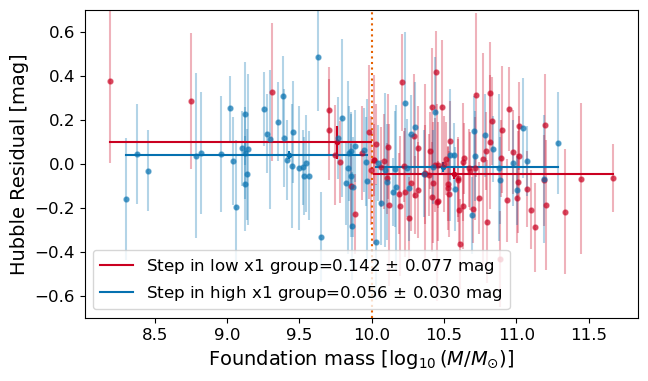

In [42]:
fig = plt.figure(figsize=(9, 4))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
yb1 = [np.median(lowx1SN_below_mu)]*100
xb1 = np.linspace(np.min(lowx1SN_below_mass),np.max(lowx1SN_below_mass),100)
yb2 = [np.median(lowx1SN_above_mu)]*100
xb2 = np.linspace(np.min(lowx1SN_above_mass),np.max(lowx1SN_above_mass),100)
aB,bB = np.polyfit(lowx1_SN_mass,lowx1_SN_mu,1)

yr1 = [np.median(highx1SN_below_mu)]*100
xr1 = np.linspace(np.min(highx1SN_below_mass),np.max(highx1SN_below_mass),100)
yr2 = [np.median(highx1SN_above_mu)]*100
xr2 = np.linspace(np.min(highx1SN_above_mass),np.max(highx1SN_above_mass),100)
aR,bR = np.polyfit(highx1_SN_mass,highx1_SN_mu,1)

# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(lowx1_SN_mass,lowx1_SN_mu, color='#ca0020',zorder=5,marker='o',s=13,alpha=0.5)
#ax_scatter.plot(blueSN_mass,aB*np.array(blueSN_mass)+bB,color='#0571b0')
ax_scatter.errorbar(lowx1_SN_mass,lowx1_SN_mu,  yerr=lowx1_SN_err, fmt = 'o',alpha=0.3,color='#ca0020',markersize=2)

ax_scatter.scatter(highx1_SN_mass,highx1_SN_mu, color='#0571b0',zorder=5,marker='o',s=13,alpha=0.5)
#ax_scatter.plot(redSN_mass,aR*np.array(redSN_mass)+bR,color='#ca0020')
ax_scatter.errorbar(highx1_SN_mass,highx1_SN_mu,  yerr=highx1_SN_err, fmt = 'o',alpha=0.3,color='#0571b0',markersize=2)
ax_scatter.axvline(step,linestyle='dotted',color='#e66101',markersize=4)

ax_scatter.plot(xb1,yb1,color='#ca0020',markersize=4,label = f"Step in low x1 group={lowx1SN_mass_step:.3f} $\\pm$ {lowx1SN_mass_step_err:.3f} mag")
ax_scatter.plot(xb2,yb2,color='#ca0020',markersize=4)
ax_scatter.errorbar([np.median(lowx1SN_below_mass),np.median(lowx1SN_above_mass)],[np.median(lowx1SN_below_mu),np.median(lowx1SN_above_mu)],
                    yerr=[lowx1SNm_std_1,lowx1SNm_std_2],fmt='o',color='#ca0020',markersize=3)

ax_scatter.plot(xr1,yr1,color='#0571b0',markersize=4,label = f"Step in high x1 group={highx1SN_mass_step:.3f} $\\pm$ {highx1SN_mass_step_err:.3f} mag")
ax_scatter.plot(xr2,yr2,color='#0571b0',markersize=4)
ax_scatter.errorbar([np.median(highx1SN_below_mass),np.median(highx1SN_above_mass)],[np.median(highx1SN_below_mu),np.median(highx1SN_above_mu)],
                    yerr=[highx1SNm_std_1,highx1SNm_std_2],fmt='o',color='#0571b0',markersize=3)


ax_scatter.set_xlabel('Foundation mass [$\log_{10}(M / M_{\odot})$]',fontsize=14)
ax_scatter.set_ylabel('Hubble Residual [mag]',fontsize=14)
# ax_scatter.axes.set_xlim(0.2, 2.5)
ax_scatter.axes.set_ylim(-0.7, 0.7)
#ax_scatter.text(10.5, -0.6, f'Step: {mass_step_median:.4f} ± {mass_step_err_median:.4f}', fontsize=10)
ax_scatter.legend(fontsize=12)
#ax_scatter.legend(loc='lower right')
plt.tick_params(labelsize=12)
#plt.savefig('FN_HR vs M stretch.pdf',bbox_inches='tight')
plt.show()

# SN stretch vs Host mass

In [43]:
# Mass and Hubble Residuals arrays for SNe in high-mass galaxies
above_m2 = []
above_x1 = []
above_x1err = []

# Mass and Hubble Residuals arrays for SNe in low-mass galaxies
below_m2 = []
below_x1 = []
below_x1err = []

for i in range(len(list(FN_Host_Properties['LOGMASS']))):
    if float(list(FN_Host_Properties['LOGMASS'])[i]) >= step: # Position of the mass step
        above_m2.append(float(list(FN_Host_Properties['LOGMASS'])[i]))
        above_x1.append(float(stretch[i]))
        above_x1err.append(float(x1ERR[i]))
    else: 
        below_m2.append(float(list(FN_Host_Properties['LOGMASS'])[i]))
        below_x1.append(float(stretch[i]))
        below_x1err.append(float(x1ERR[i]))


# Bootstrap resampling
boots1x1_m = bootstrap((np.array(below_x1), ), np.mean, confidence_level=0.9,method='percentile')
std_1x1_m = boots1x1_m.standard_error
boots2x1_m = bootstrap((np.array(above_x1), ), np.mean, confidence_level=0.9,method='percentile')
std_2x1_m = boots2x1_m.standard_error

/var/folders/x2/6fv_ssn576dcwskmwrtlfbhr0000gn/T/ipykernel_55289/1556242155.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


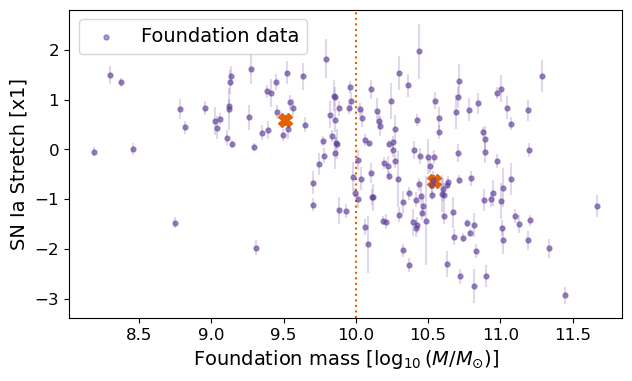

In [44]:
fig = plt.figure(figsize=(9, 4))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
y1 = [np.median(below_x1)]*100
x1 = np.linspace(np.min(below_m2),np.max(below_m2),100)
y2 = [np.median(above_x1)]*100
x2 = np.linspace(np.min(above_m2),np.max(above_m2),100)
# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(FN_Host_Properties['LOGMASS'],stretch, color='#5e3c99',zorder=5,marker='o',s=13,alpha=0.5,label='Foundation data')
ax_scatter.errorbar(FN_Host_Properties['LOGMASS'],stretch, yerr=x1ERR, fmt = 'o',alpha=0.2,color='#5e3c99',markersize=2)
ax_scatter.axvline(step,linestyle='dotted',color='#e66101',markersize=4)
# ax_scatter.plot(x1,y1,color='#d7191c',markersize=4)
# ax_scatter.plot(x2,y2,color='#d7191c',markersize=4)
ax_scatter.errorbar([np.median(below_m2),np.median(above_m2)],[np.median(below_x1),np.median(above_x1)],
                    yerr=[std_1x1_m,std_2x1_m],fmt='X',color='#e66101',markersize=10)

ax_scatter.set_xlabel('Foundation mass [$\log_{10}(M / M_{\odot})$]',fontsize=14)
ax_scatter.set_ylabel('SN Ia Stretch [x1]',fontsize=14)
# ax_scatter.axes.set_xlim(0.2, 2.5)
#ax_scatter.axes.set_ylim(-0.7, 0.7)
#ax_scatter.text(10.5, -0.6, f'Step: {mass_step_median:.4f} ± {mass_step_err_median:.4f}', fontsize=10)
ax_scatter.legend(fontsize=14)
plt.tick_params(labelsize = 12)
#ax_scatter.legend(loc='lower right')
plt.tight_layout()
#plt.savefig('FN M vs x1.pdf', bbox_inches = 'tight')
plt.show()

# SN stretch vs Host (U-R)

In [45]:
# Mass and Hubble Residuals arrays for SNe in high-mass galaxies
above_UR2 = []
above_x12 = []
above_x12err = []

# Mass and Hubble Residuals arrays for SNe in low-mass galaxies
below_UR2 = []
below_x12 = []
below_x12err = []

for i in range(len(list(FN_Host_Properties['U-R Color']))):
    if float(list(FN_Host_Properties['U-R Color'])[i]) >= median_UR: # Position of the mass step
        above_UR2.append(float(list(FN_Host_Properties['U-R Color'])[i]))
        above_x12.append(float(stretch[i]))
        above_x12err.append(float(x1ERR[i]))
    else: 
        below_UR2.append(float(list(FN_Host_Properties['U-R Color'])[i]))
        below_x12.append(float(stretch[i]))
        below_x12err.append(float(x1ERR[i]))


# Bootstrap resampling
boots1x1_ur = bootstrap((np.array(below_x12), ), np.mean, confidence_level=0.9,method='percentile')
std_1x1_ur = boots1x1_ur.standard_error
boots2x1_ur = bootstrap((np.array(above_x12), ), np.mean, confidence_level=0.9,method='percentile')
std_2x1_ur = boots2x1_ur.standard_error


/var/folders/x2/6fv_ssn576dcwskmwrtlfbhr0000gn/T/ipykernel_55289/1282452771.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


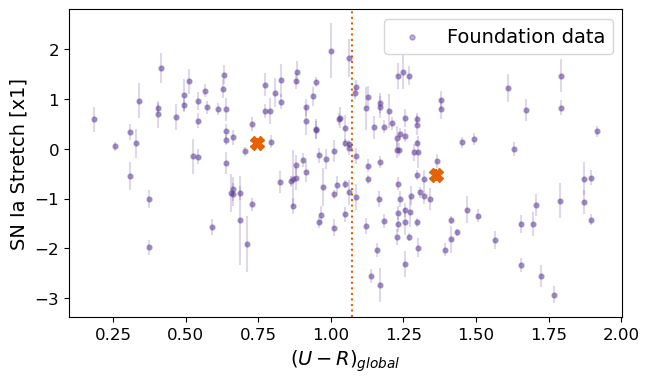

In [46]:
fig = plt.figure(figsize=(9, 4))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
y1 = [np.median(below_x12)]*100
x1 = np.linspace(np.min(below_UR2),100)
y2 = [np.median(above_x12)]*100
x2 = np.linspace(np.min(above_UR2),np.max(above_UR2),100)
# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(FN_Host_Properties['U-R Color'],stretch, color='#5e3c99',zorder=10,marker='o',s=13,alpha=0.4,label='Foundation data')
ax_scatter.errorbar(FN_Host_Properties['U-R Color'],stretch, yerr=x1ERR, fmt = 'o',alpha=0.2,color='#5e3c99',markersize=2)
ax_scatter.axvline(median_UR,linestyle='dotted',color='#e66101',markersize=4)
# ax_scatter.plot(x1,y1,color='#d7191c',markersize=4)
# ax_scatter.plot(x2,y2,color='#d7191c',markersize=4)
ax_scatter.errorbar([np.mean(below_UR2),np.mean(above_UR2)],[np.mean(below_x12),np.mean(above_x12)],
                    yerr=[std_1x1_ur,std_2x1_ur],fmt='X',color='#e66101',markersize=10)

ax_scatter.set_xlabel('$(U-R)_{global}$',fontsize=14)
ax_scatter.set_ylabel('SN Ia Stretch [x1]',fontsize=14)
# ax_scatter.axes.set_xlim(0.2, 2.5)
#ax_scatter.axes.set_ylim(-0.7, 0.7)
#ax_scatter.text(10.5, -0.6, f'Step: {mass_step_median:.4f} ± {mass_step_err_median:.4f}', fontsize=10)
ax_scatter.legend(fontsize=14)
#ax_scatter.legend(loc='lower right')
plt.tick_params(labelsize = 12)
plt.tight_layout()
#plt.savefig('FN UR vs x1.pdf', bbox_inches = 'tight')
plt.show()